# Feature: Distances Between Co-Occurrence Matrix Rows

This is a "magic" (leaky) approach used by [Stanislav Semenov](https://www.kaggle.com/stasg7) in the [Avito Duplicate Ads Detection competition](https://www.kaggle.com/c/avito-duplicate-ads-detection).

We'll populate a sparse binary co-occurrence matrix $C \in \{0,1\}^{|Q|\times|Q|}$ (1 means such pair appears in the dataset, 0 otherwise), and compute vector distances between its rows. Also, in addition to the original approach, we'll SVD the matrix and calculate some distances on the reduced matrix.

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import os
import sys

In [3]:
from scipy.sparse import csr_matrix, dok_matrix

In [4]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

## Config

Automatically discover the paths to various data folders and compose the project structure.

In [5]:
project = kg.Project.discover()

Identifier for storing these features on disk and referring to them later.

In [6]:
feature_list_id = 'magic_cooccurrence_matrix'

Number of SVD components.

In [7]:
NUM_SVD_COMPONENTS = 150
NUM_SVD_ITERATIONS = 30

Make subsequent runs reproducible.

In [8]:
RANDOM_SEED = 42

## Read data

Original question datasets.

In [9]:
df_train = pd.read_csv(project.data_dir + 'train.csv').fillna('')
df_test = pd.read_csv(project.data_dir + 'test.csv').fillna('')

## Build features

Assign a unique index to each unique question text.

In [10]:
df_all_pairs = pd.concat([df_train[['question1', 'question2']], df_test[['question1', 'question2']]])

In [11]:
df_unique_texts = pd.DataFrame(np.unique(df_all_pairs.values.ravel()), columns=['question'])

In [12]:
question_ids = pd.Series(df_unique_texts.index.values, index=df_unique_texts['question'].values).to_dict()

In [13]:
df_all_pairs['q1_id'] = df_all_pairs['question1'].map(question_ids)
df_all_pairs['q2_id'] = df_all_pairs['question2'].map(question_ids)

### Build cooccurrence matrix

Use the cached matrix if it exists, otherwise build a new one.

In [14]:
saved_matrix_path = project.trained_model_dir + f'{feature_list_id}_sparse_csr.pickle'

In [15]:
if os.path.exists(saved_matrix_path):
    cooccurrence_csr = kg.io.load(saved_matrix_path)

else:
    cooccurrence = dok_matrix((len(question_ids), len(question_ids)), dtype='b')
    for i, row in progressbar(df_all_pairs.iterrows(), total=len(df_all_pairs), file=sys.stdout):
        cooccurrence[row['q1_id'], row['q2_id']] = 1
        cooccurrence[row['q2_id'], row['q1_id']] = 1

    cooccurrence_csr = cooccurrence.tocsr(copy=True)
    kg.io.save(cooccurrence_csr, saved_matrix_path)

100%|██████████| 2750086/2750086 [03:44<00:00, 12245.04it/s]


### Extract distance features from the raw matrix

In [16]:
id_pairs = df_all_pairs[['q1_id', 'q2_id']].values

In [17]:
def get_raw_matrix_distances(id_pair):
    q1_row = cooccurrence_csr[id_pair[0]]
    q2_row = cooccurrence_csr[id_pair[1]]
    
    return [
        cosine_distances(q1_row, q2_row)[0][0],
        euclidean_distances(q1_row, q2_row)[0][0],
    ]

In [18]:
distances_raw = kg.jobs.map_batch_parallel(
    id_pairs,
    item_mapper=get_raw_matrix_distances,
    batch_size=1000,
)

Batches: 100%|██████████| 2751/2751 [6:25:57<00:00,  7.81s/it]  


### SVD the matrix and calculate some distances there

In [19]:
svd = TruncatedSVD(
    n_components=NUM_SVD_COMPONENTS,
    n_iter=NUM_SVD_ITERATIONS,
    random_state=RANDOM_SEED,
)

In [20]:
X_svd = svd.fit_transform(cooccurrence_csr)

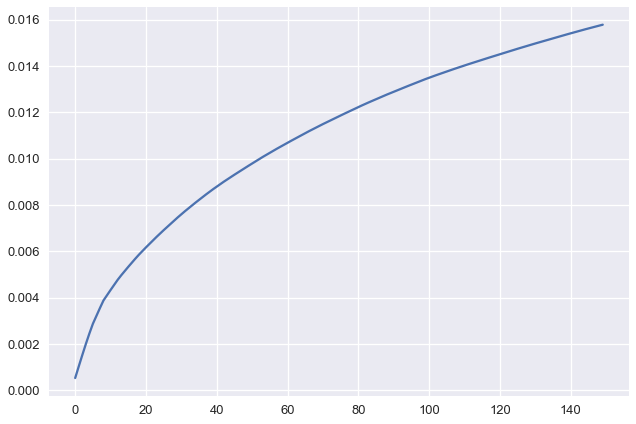

In [21]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))

In [22]:
def get_svd_matrix_distances(id_pair):
    q1_row = X_svd[id_pair[0]].reshape(1, -1)
    q2_row = X_svd[id_pair[1]].reshape(1, -1)
    
    return [
        cosine_distances(q1_row, q2_row)[0][0],
        euclidean_distances(q1_row, q2_row)[0][0],
        manhattan_distances(q1_row, q2_row)[0][0],
    ]

In [23]:
distances_svd = kg.jobs.map_batch_parallel(
    id_pairs,
    item_mapper=get_svd_matrix_distances,
    batch_size=1000,
)

Batches: 100%|██████████| 2751/2751 [02:10<00:00, 21.03it/s]


### Build final features

In [24]:
distances = np.hstack([distances_raw, distances_svd])

In [25]:
X_train = distances[:len(df_train)]
X_test = distances[len(df_train):]

In [26]:
print('X_train:', X_train.shape)
print('X_test: ', X_test.shape)

X_train: (404290, 5)
X_test:  (2345796, 5)


## Save features

In [29]:
feature_names = [
    'magic_comatrix_cosine',
    'magic_comatrix_euclidean',
    'magic_comatrix_svd_cosine',
    'magic_comatrix_svd_euclidean',
    'magic_comatrix_svd_manhattan',
]

In [30]:
project.save_features(X_train, X_test, feature_names, feature_list_id)